In [ ]:
library(tidyverse)
library(naniar)
library(visdat)
library(ggplot2)
library(lubridate)
library(gridExtra)
library(GGally)
library(corrr)
library(dplyr)
library(car)
library(mgcv)
library(ggfortify)
library(reshape)

In [10]:
# data = read.csv('data/fatal-police-shootings-data.csv', na.strings=c("","NA"))
data = read.csv('data/trimmed_weather_police.csv', na.strings=c("","NA"))

### Initial EDA

> DF shape, column names, data-type setting, dropping irrelevant features

In [11]:
dim(data)
names(data)

[1] 6579   28

[1] "X"                       "id"                     
 [3] "name"                    "date"                   
 [5] "manner_of_death"         "armed"                  
 [7] "age"                     "gender"                 
 [9] "race"                    "city"                   
[11] "state"                   "signs_of_mental_illness"
[13] "threat_level"            "flee"                   
[15] "body_camera"             "longitude"              
[17] "latitude"                "is_geocoding_exact"     
[19] "smha_exp_per_capita"     "smi_prevalance"         
[21] "temp"                    "humidity"               
[23] "precipprob"              "snow"                   
[25] "pressure"                "uvindex"                
[27] "moonphase"               "precip"

In [12]:
head(data)

,X,id,name,date,manner_of_death,armed,age,gender,race,city,⋯,smha_exp_per_capita,smi_prevalance,temp,humidity,precipprob,snow,pressure,uvindex,moonphase,precip
,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
1,0,3,Tim Elliot,2015-01-02,shot,gun,53,M,A,Shelton,⋯,128.46,0.0472,32.0,94.4,100,False,1021.1,2,0.46,True
2,1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47,M,W,Aloha,⋯,234.87,0.0483,32.2,75.9,0,False,1023.6,3,0.46,False
3,2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23,M,H,Wichita,⋯,124.11,0.0412,32.7,84.7,100,False,1013.3,3,0.49,True
4,3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32,M,W,San Francisco,⋯,174.98,0.0379,46.3,76.2,0,False,1028.6,4,0.50,False
5,4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39,M,H,Evans,⋯,121.90,0.0390,1.4,70.3,0,False,NA,5,0.50,False
6,5,11,Kenneth Joe Brown,2015-01-04,shot,gun,18,M,W,Guthrie,⋯,59.29,0.0459,21.5,59.0,0,False,1034.9,6,0.50,False


In [13]:
# number of unique values
for (c in names(data)) { print(paste0(c, ": ", length(unique(data[[c]])))) }

[1] "X: 6579"
[1] "id: 6579"
[1] "name: 6280"
[1] "date: 2362"
[1] "manner_of_death: 2"
[1] "armed: 98"
[1] "age: 80"
[1] "gender: 3"
[1] "race: 7"
[1] "city: 2794"
[1] "state: 51"
[1] "signs_of_mental_illness: 2"
[1] "threat_level: 3"
[1] "flee: 5"
[1] "body_camera: 2"
[1] "longitude: 5781"
[1] "latitude: 5137"
[1] "is_geocoding_exact: 2"
[1] "smha_exp_per_capita: 51"
[1] "smi_prevalance: 47"
[1] "temp: 839"
[1] "humidity: 1713"
[1] "precipprob: 3"
[1] "snow: 2"
[1] "pressure: 400"
[1] "uvindex: 11"
[1] "moonphase: 101"
[1] "precip: 2"


In [14]:
# for (i in 1:length(data$armed)){
#     if (data$armed[i] == 'gun') {next}
#     else if (data$armed[i] == 'knife') {next}
#     else if (data$armed[i] == 'vehicle') {next}
#     else if (data$armed[i] == 'unarmed') {next}
#     else if (data$armed[i] == 'undetermined') {next}
#     else {data$armed[i] = 'other'}
# } 

# For some reason, this kept throwing an error for me, so I tried another method
data = data %>% 
  mutate(armed = case_when(
    armed == "gun" ~ "gun",
    armed == "knife" ~ "knife",
    armed == "vehicle" ~ "vehicle",
    armed == "unarmed" ~ "unarmed",
    armed == "undetermined" ~ "undetermined",
    TRUE ~ "other",
  )
)

In [15]:
# Convert features to factor and numeric as appropriate

# CHECK: armed, city, date, longitude, latitude

features_to_drop = c("id", "name", "city")
factor_cols = c("manner_of_death", "armed", "gender", "race", "state", "signs_of_mental_illness", "threat_level", "flee", "body_camera")
numeric_cols = c("age")

In [16]:
data = data[,!(names(data) %in% features_to_drop)]
data <- data %>% 
    mutate(across(.cols=all_of(factor_cols), .fns = as.factor))
data <- data %>% 
    mutate(across(.cols=all_of(numeric_cols), .fns = as.numeric))

In [17]:
# convert date from character to date format
data <- data %>% 
    mutate(across(.cols="date", .fns = as_date))

> Explore feature types, what info they contain

In [18]:
summary(data)

       X             date                    manner_of_death
 Min.   :   0   Min.   :2015-01-02   shot            :6253  
 1st Qu.:1644   1st Qu.:2016-09-06   shot and Tasered: 326  
 Median :3289   Median :2018-05-25                          
 Mean   :3289   Mean   :2018-06-22                          
 3rd Qu.:4934   3rd Qu.:2020-03-24                          
 Max.   :6578   Max.   :2022-04-20                          
                                                            
          armed           age         gender       race          state     
 gun         :3772   Min.   : 6.00   F   : 305   A   :  98   CA     : 980  
 knife       : 951   1st Qu.:27.00   M   :6268   B   :1500   TX     : 591  
 other       :1021   Median :35.00   NA's:   6   H   :1046   FL     : 431  
 unarmed     : 410   Mean   :37.13               N   :  85   AZ     : 293  
 undetermined: 208   3rd Qu.:45.00               O   :  47   GA     : 245  
 vehicle     : 217   Max.   :91.00               W   :28

Run Univariate analysis of each feature

In [19]:
attach(data)

The following objects are masked from package:datasets:

    precip, pressure




[1] "manner_of_death: Unique Count: 2"
[1] ""
[1] "armed: Unique Count: 6"


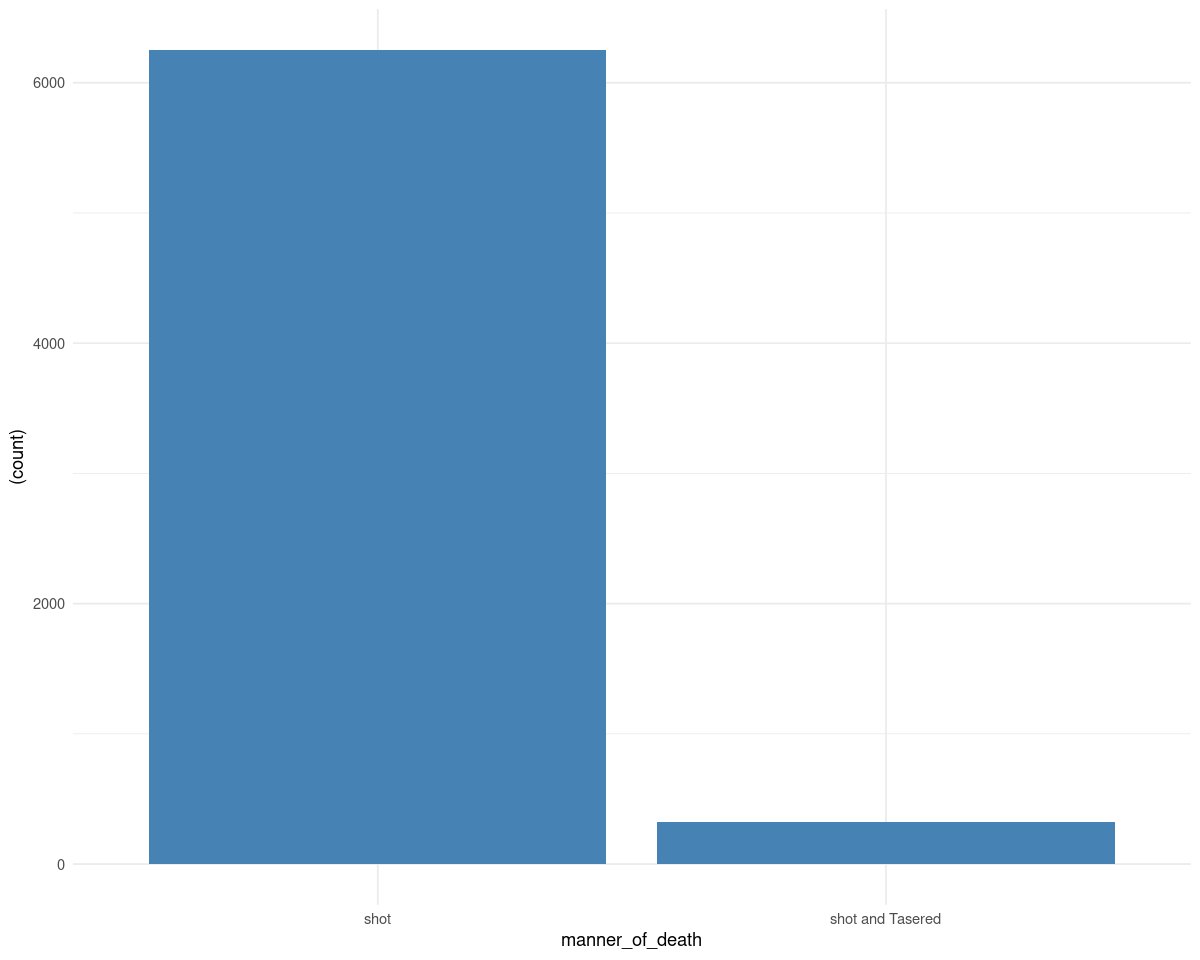

[1] ""
[1] "gender: Unique Count: 3"


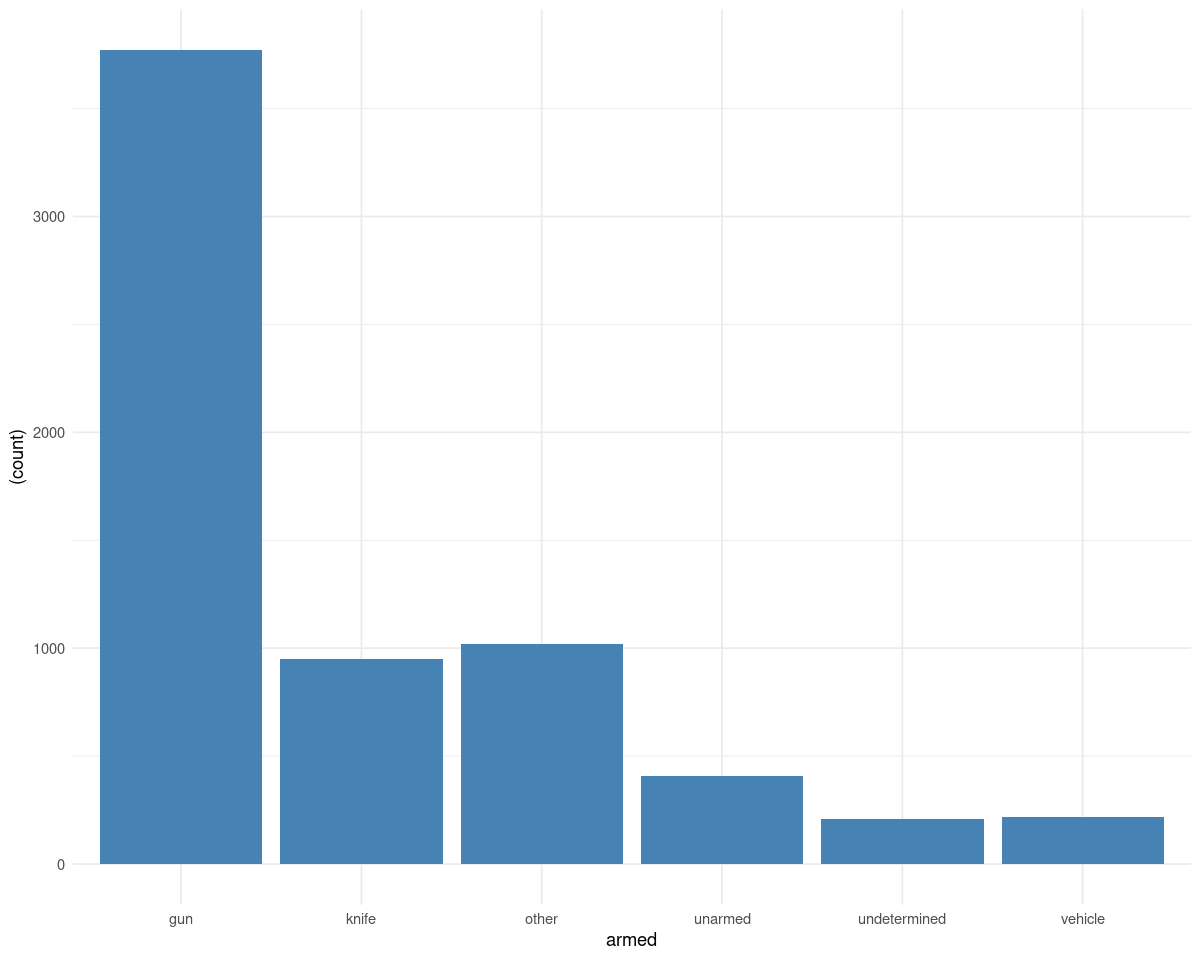

[1] ""
[1] "race: Unique Count: 7"


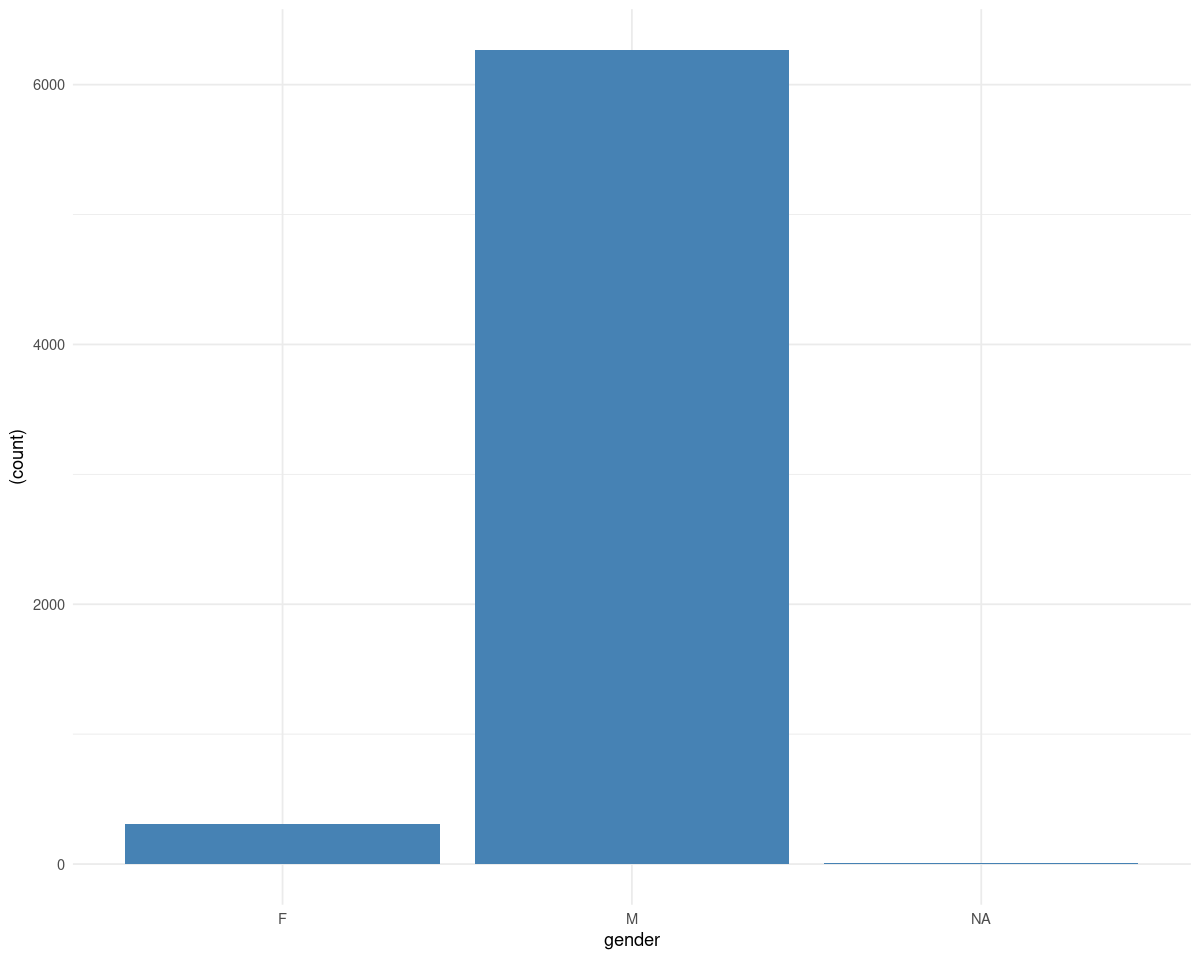

[1] ""
[1] "state: Unique Count: 51"
   Var1 Freq
1    AK   39
2    AL  119
3    AR   88
4    AZ  293
5    CA  980
6    CO  242
7    CT   21
8    DC   22
9    DE   16
10   FL  431
11   GA  245
12   HI   34
13   IA   38
14   ID   55
15   IL  136
16   IN  117
17   KS   64
18   KY  116
19   LA  127
20   MA   41
21   MD   97
22   ME   29
23   MI  112
24   MN   72
25   MO  155
26   MS   87
27   MT   38
28   NC  183
29   ND   13
30   NE   33
31   NH   18
32   NJ   81
33   NM  141
34   NV  115
35   NY  122
36   OH  179
37   OK  187
38   OR  110
39   PA  137
40   RI    4
41   SC  102
42   SD   21
43   TN  179
44   TX  591
45   UT   72
46   VA  115
47   VT    9
48   WA  179
49   WI  102
50   WV   56
51   WY   16
[1] ""
[1] "signs_of_mental_illness: Unique Count: 2"


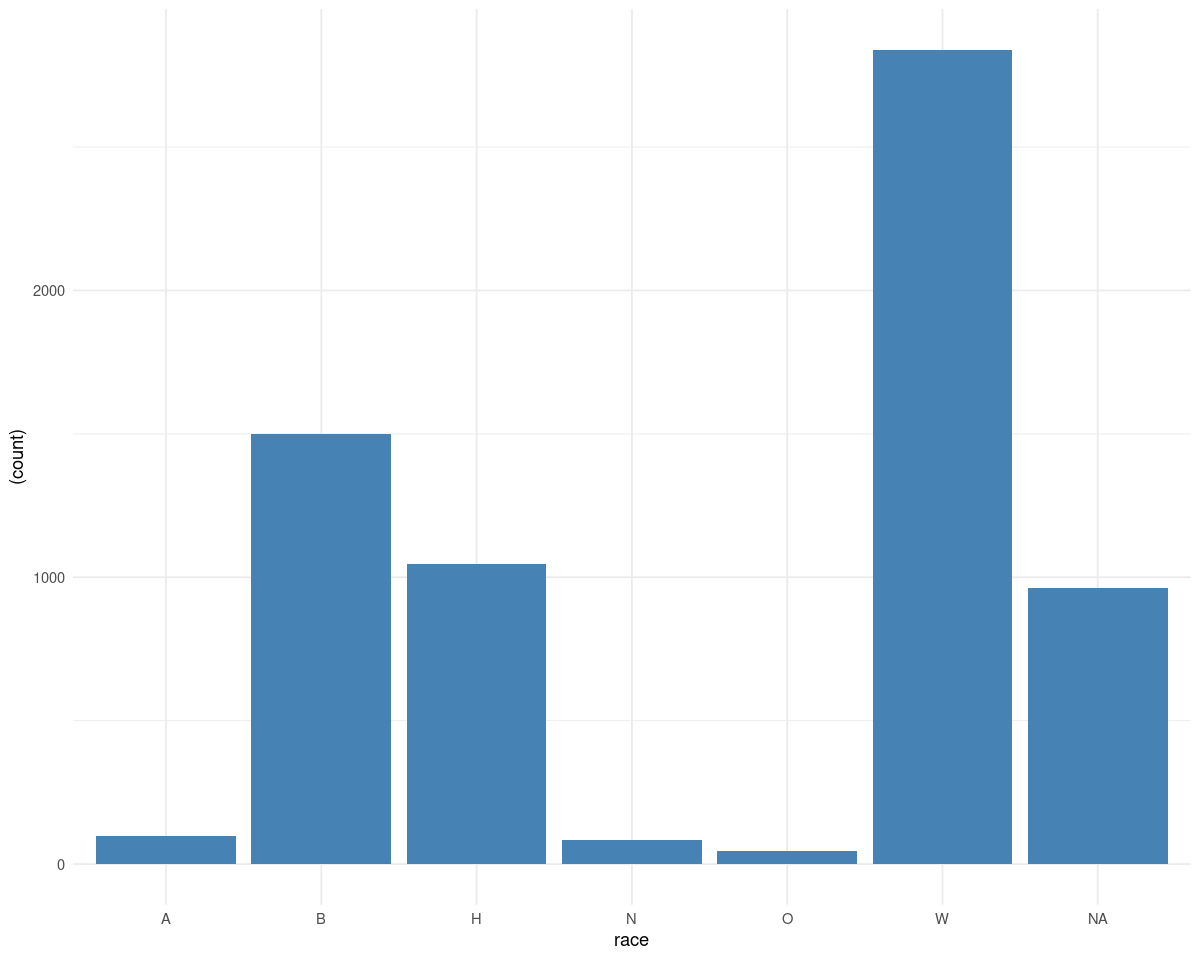

[1] ""
[1] "threat_level: Unique Count: 3"


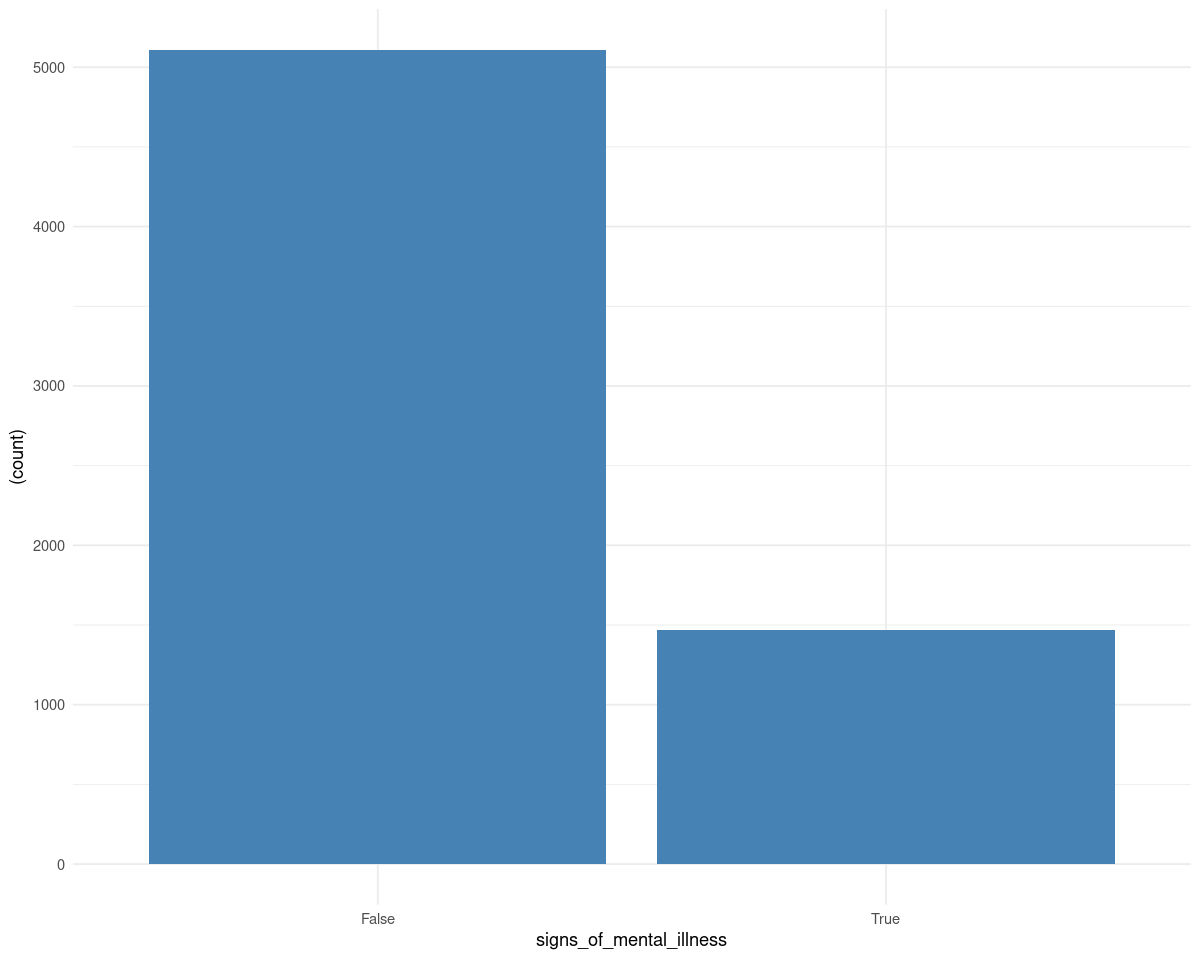

[1] ""
[1] "flee: Unique Count: 5"


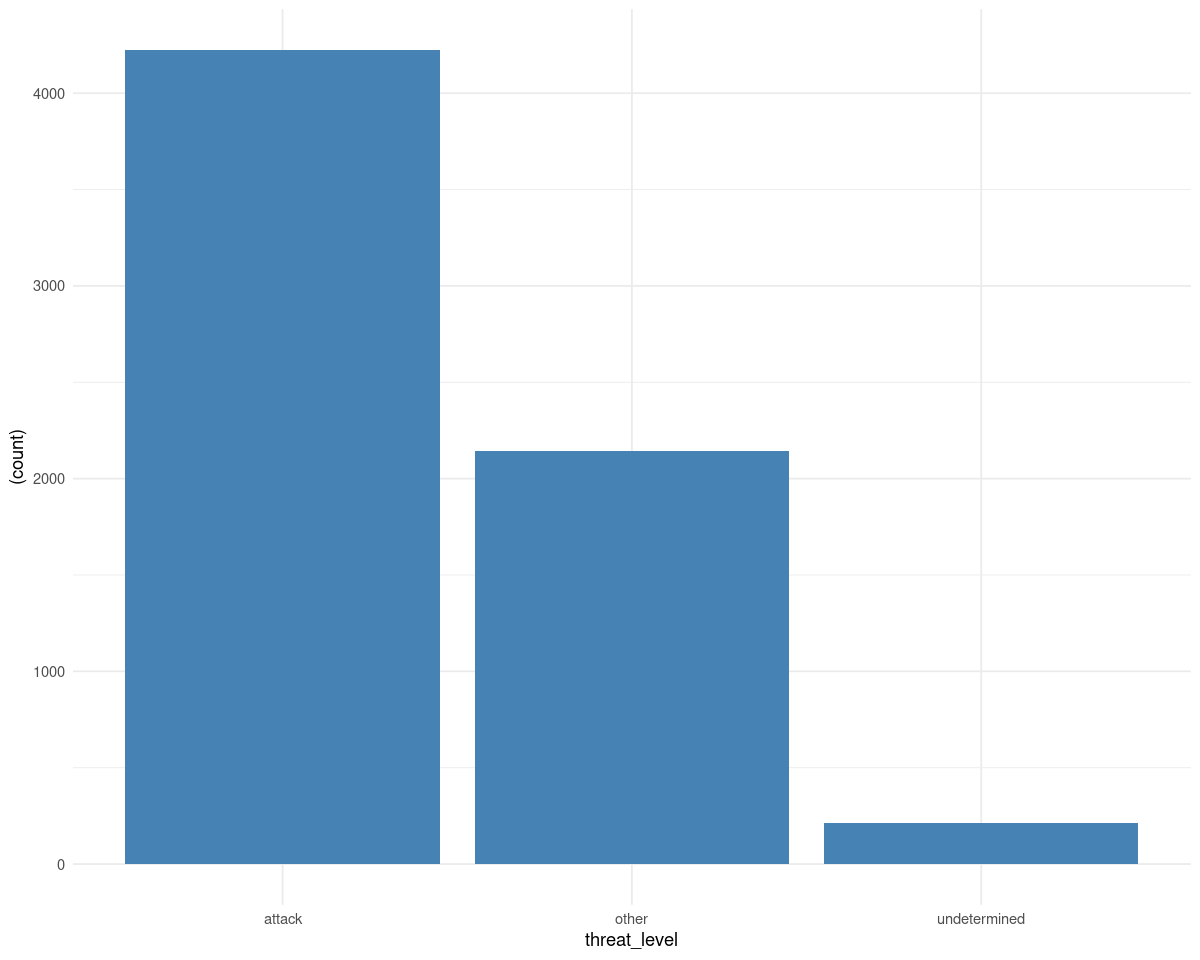

[1] ""
[1] "body_camera: Unique Count: 2"


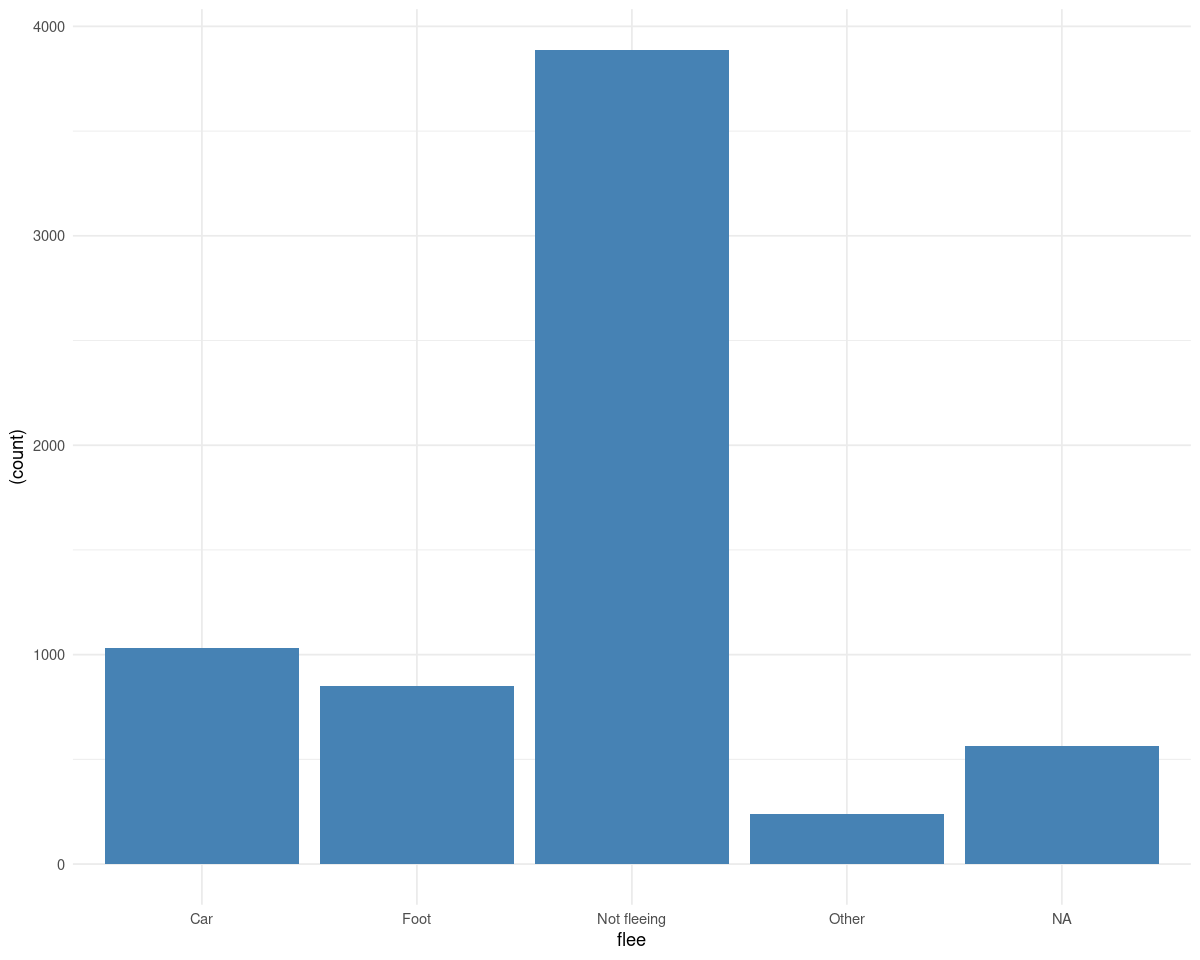

[1] ""


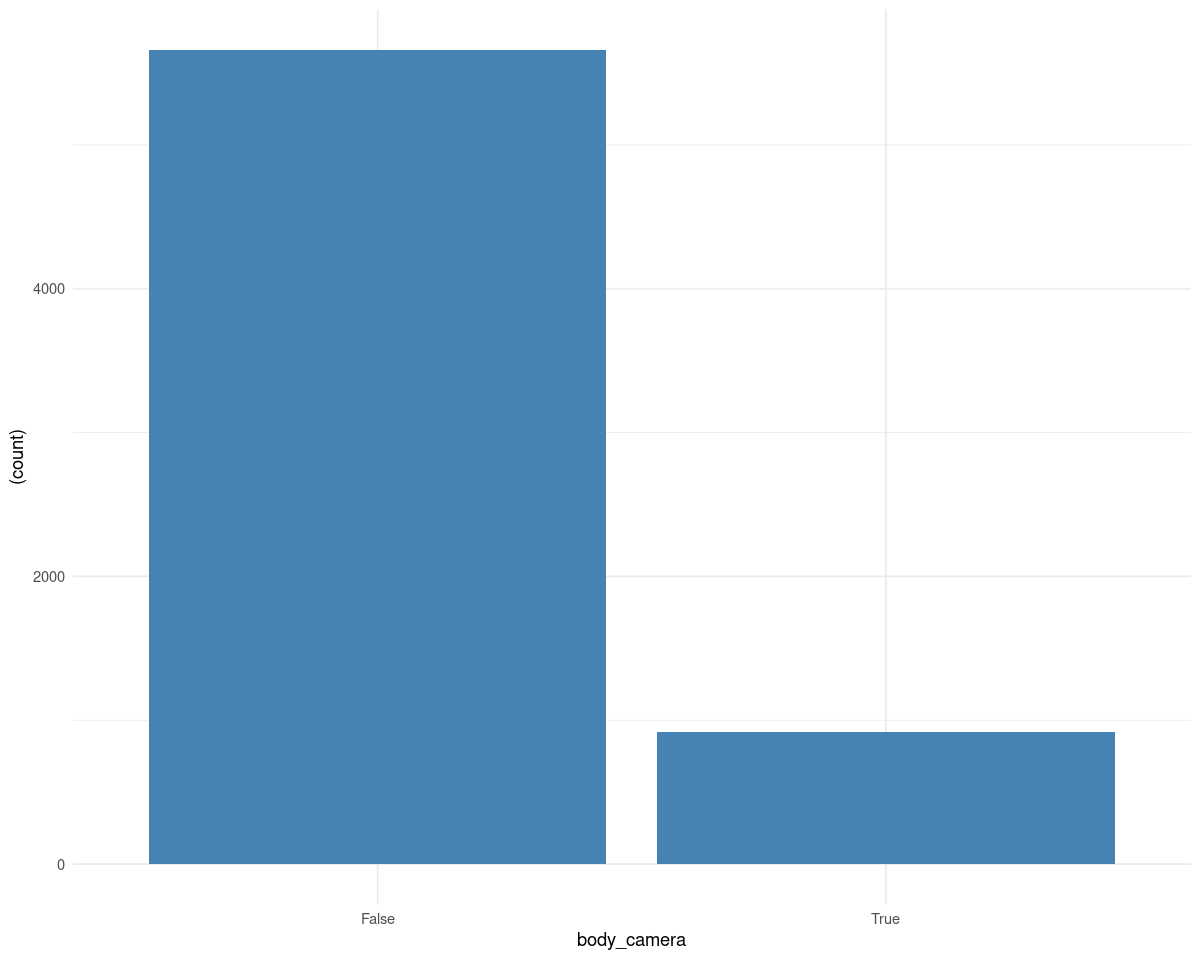

In [20]:
options(repr.plot.width=10, repr.plot.height=8)
for (c in factor_cols) {
    print(paste0(c, ": Unique Count: ", length(unique(data[[c]]))))
    if (length(unique(data[[c]])) < 10) {
        print(ggplot(data=data, aes(x=unlist(data[c]), y=(..count..))) + geom_bar(fill="steelblue") + theme_minimal() + xlab(c))
    } else {
        print(as.data.frame(table(data[c])))
    }
    print("")
}

In [21]:
# print(summary(data$armed))
unique(data$armed)

[1] gun          unarmed      other        knife        vehicle     
[6] undetermined
Levels: gun knife other unarmed undetermined vehicle

Check bivariate vs response

In [22]:
# MI with gender - higher proportion of women classified as MI
MI_gender = table(signs_of_mental_illness, gender)
MI_gender
prop.table(MI_gender, margin = 2)

                       gender
signs_of_mental_illness    F    M
                  False  206 4897
                  True    99 1371

                       gender
signs_of_mental_illness         F         M
                  False 0.6754098 0.7812699
                  True  0.3245902 0.2187301

In [23]:
# MI with race - black lowest at .155, white highest at 0.289
MI_race = table(signs_of_mental_illness, race)
MI_race
prop.table(MI_race, margin = 2)

                       race
signs_of_mental_illness    A    B    H    N    O    W
                  False   73 1258  862   70   37 2009
                  True    25  242  184   15   10  830

                       race
signs_of_mental_illness         A         B         H         N         O
                  False 0.7448980 0.8386667 0.8240918 0.8235294 0.7872340
                  True  0.2551020 0.1613333 0.1759082 0.1764706 0.2127660
                       race
signs_of_mental_illness         W
                  False 0.7076435
                  True  0.2923565

In [24]:
# MI with manner_of_death - higher shot and tasered
MI_MoD= table(signs_of_mental_illness, manner_of_death)
MI_MoD
prop.table(MI_MoD, margin = 2)

                       manner_of_death
signs_of_mental_illness shot shot and Tasered
                  False 4894              215
                  True  1359              111

                       manner_of_death
signs_of_mental_illness      shot shot and Tasered
                  False 0.7826643        0.6595092
                  True  0.2173357        0.3404908

In [25]:
# MI with state - KY lowest at 0.09, NH and VT highest at 0.45 (though very few cases)
MI_state = table(signs_of_mental_illness, state)
MI_state
prop.table(MI_state, margin = 2)

                       state
signs_of_mental_illness  AK  AL  AR  AZ  CA  CO  CT  DC  DE  FL  GA  HI  IA  ID
                  False  32  92  76 238 764 210  15  19  12 316 196  29  31  47
                  True    7  27  12  55 216  32   6   3   4 115  49   5   7   8
                       state
signs_of_mental_illness  IL  IN  KS  KY  LA  MA  MD  ME  MI  MN  MO  MS  MT  NC
                  False 114  88  49 105  95  28  69  26  82  51 132  74  33 141
                  True   22  29  15  11  32  13  28   3  30  21  23  13   5  42
                       state
signs_of_mental_illness  ND  NE  NH  NJ  NM  NV  NY  OH  OK  OR  PA  RI  SC  SD
                  False  12  24   9  62 120  84  77 133 147  74  99   4  82  15
                  True    1   9   9  19  21  31  45  46  40  36  38   0  20   6
                       state
signs_of_mental_illness  TN  TX  UT  VA  VT  WA  WI  WV  WY
                  False 140 472  53  83   4 119  76  44  12
                  True   39 119  19  32   5 

                       state
signs_of_mental_illness         AK         AL         AR         AZ         CA
                  False 0.82051282 0.77310924 0.86363636 0.81228669 0.77959184
                  True  0.17948718 0.22689076 0.13636364 0.18771331 0.22040816
                       state
signs_of_mental_illness         CO         CT         DC         DE         FL
                  False 0.86776860 0.71428571 0.86363636 0.75000000 0.73317865
                  True  0.13223140 0.28571429 0.13636364 0.25000000 0.26682135
                       state
signs_of_mental_illness         GA         HI         IA         ID         IL
                  False 0.80000000 0.85294118 0.81578947 0.85454545 0.83823529
                  True  0.20000000 0.14705882 0.18421053 0.14545455 0.16176471
                       state
signs_of_mental_illness         IN         KS         KY         LA         MA
                  False 0.75213675 0.76562500 0.90517241 0.74803150 0.68292683
               

In [26]:
# MI with threat_level - undetermined much lower than others, prob not helpful
MI_threat = table(signs_of_mental_illness, threat_level)
MI_threat
prop.table(MI_threat, margin = 2)

                       threat_level
signs_of_mental_illness attack other undetermined
                  False   3311  1618          180
                  True     914   524           32

                       threat_level
signs_of_mental_illness    attack     other undetermined
                  False 0.7836686 0.7553688    0.8490566
                  True  0.2163314 0.2446312    0.1509434

In [27]:
# MI with flee - not fleeing is far higher than the other three options
MI_flee = table(signs_of_mental_illness, flee)
MI_flee
prop.table(MI_flee, margin = 2)

                       flee
signs_of_mental_illness  Car Foot Not fleeing Other
                  False  948  748        2716   219
                  True    86  104        1172    21

                       flee
signs_of_mental_illness        Car       Foot Not fleeing      Other
                  False 0.91682785 0.87793427  0.69855967 0.91250000
                  True  0.08317215 0.12206573  0.30144033 0.08750000

In [28]:
# MI with body_camera - higher with body camera
MI_body_camera = table(signs_of_mental_illness, body_camera)
MI_body_camera
prop.table(MI_body_camera, margin = 2)

                       body_camera
signs_of_mental_illness False True
                  False  4442  667
                  True   1219  251

                       body_camera
signs_of_mental_illness     False      True
                  False 0.7846670 0.7265795
                  True  0.2153330 0.2734205

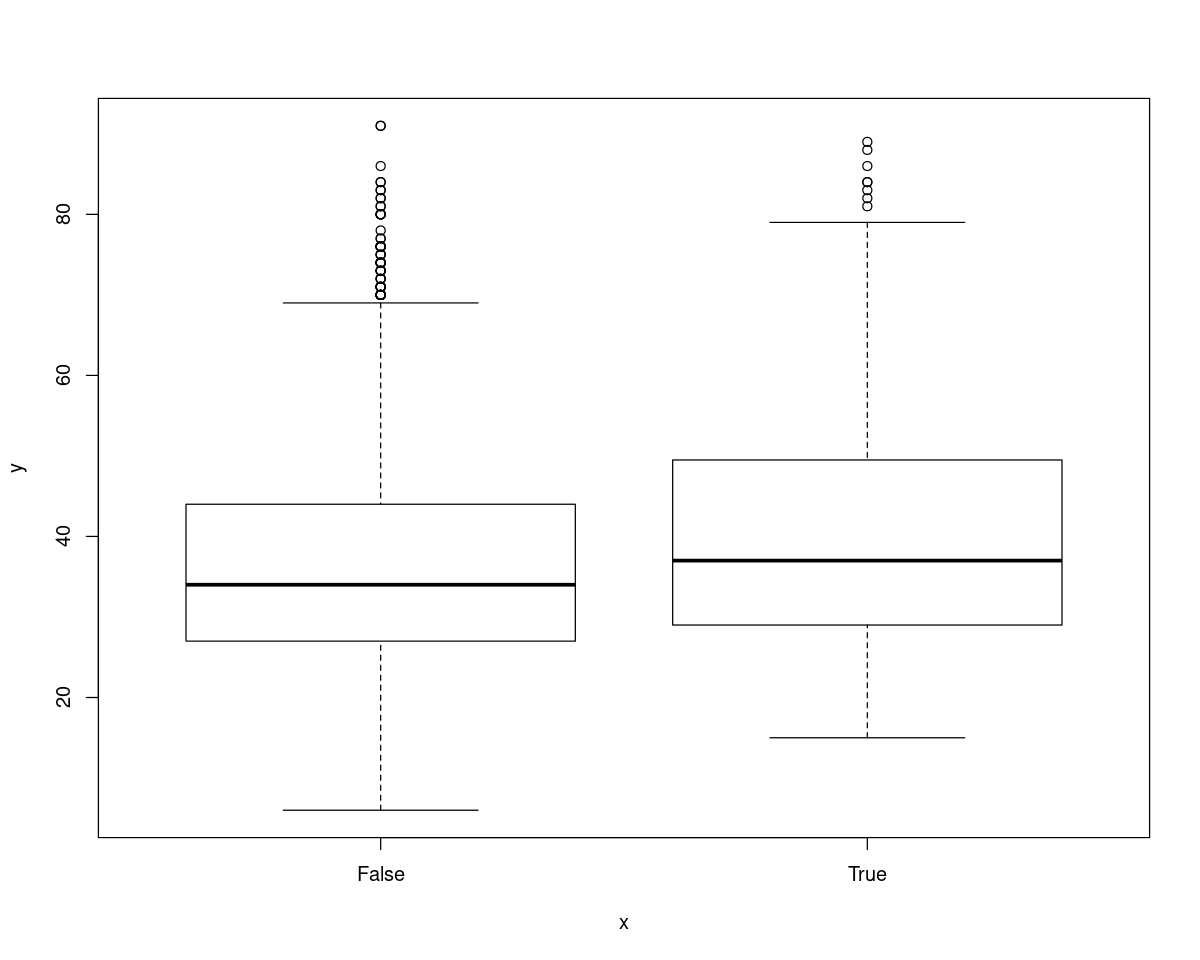

In [29]:
# MI with age - mean age a bit higher among MI than not MI
plot(signs_of_mental_illness, age)

In [30]:
plot(x=population,y=count,xlab="Population",ylab="Count")

Warning message in data.matrix(x):
“NAs introduced by coercion”


ERROR: Error in plot.default(...): formal argument "xlab" matched by multiple actual arguments


In [31]:
# MI with year - this is interesting, steadily going down YoY, then big drop off
# from 2020 to 2021
MI_year = table(signs_of_mental_illness, year(date))
MI_year
prop.table(MI_year, margin = 2)

                       
signs_of_mental_illness 2015 2016 2017 2018 2019 2020 2021 2022
                  False  734  681  712  712  738  727  654  151
                  True   260  244  232  202  207  199  115   11

                       
signs_of_mental_illness       2015       2016       2017       2018       2019
                  False 0.73843058 0.73621622 0.75423729 0.77899344 0.78095238
                  True  0.26156942 0.26378378 0.24576271 0.22100656 0.21904762
                       
signs_of_mental_illness       2020       2021       2022
                  False 0.78509719 0.85045514 0.93209877
                  True  0.21490281 0.14954486 0.06790123

In [32]:
# MI with month - proportions relatively constant across months
MI_month = table(signs_of_mental_illness, month(date))
MI_month
prop.table(MI_month, margin = 2)

                       
signs_of_mental_illness   1   2   3   4   5   6   7   8   9  10  11  12
                  False 439 452 510 449 406 432 412 442 374 437 377 379
                  True  139 122 160 131 117 115 128 137 109 111  92 109

                       
signs_of_mental_illness         1         2         3         4         5
                  False 0.7595156 0.7874564 0.7611940 0.7741379 0.7762906
                  True  0.2404844 0.2125436 0.2388060 0.2258621 0.2237094
                       
signs_of_mental_illness         6         7         8         9        10
                  False 0.7897623 0.7629630 0.7633851 0.7743271 0.7974453
                  True  0.2102377 0.2370370 0.2366149 0.2256729 0.2025547
                       
signs_of_mental_illness        11        12
                  False 0.8038380 0.7766393
                  True  0.1961620 0.2233607

In [33]:
# MI with day - not much of a pattern, though seemingly lower around end of month
MI_day = table(signs_of_mental_illness, day(date))
MI_day
prop.table(MI_day, margin = 2)

                       
signs_of_mental_illness   1   2   3   4   5   6   7   8   9  10  11  12  13  14
                  False 175 137 164 170 197 180 173 154 187 170 181 152 156 177
                  True   48  56  53  61  59  55  52  46  44  54  44  50  42  58
                       
signs_of_mental_illness  15  16  17  18  19  20  21  22  23  24  25  26  27  28
                  False 160 173 178 170 163 156 151 162 179 163 151 163 188 161
                  True   46  52  44  44  50  50  58  37  49  46  55  47  47  36
                       
signs_of_mental_illness  29  30  31
                  False 166 148 104
                  True   36  24  27

                       
signs_of_mental_illness         1         2         3         4         5
                  False 0.7847534 0.7098446 0.7557604 0.7359307 0.7695312
                  True  0.2152466 0.2901554 0.2442396 0.2640693 0.2304688
                       
signs_of_mental_illness         6         7         8         9        10
                  False 0.7659574 0.7688889 0.7700000 0.8095238 0.7589286
                  True  0.2340426 0.2311111 0.2300000 0.1904762 0.2410714
                       
signs_of_mental_illness        11        12        13        14        15
                  False 0.8044444 0.7524752 0.7878788 0.7531915 0.7766990
                  True  0.1955556 0.2475248 0.2121212 0.2468085 0.2233010
                       
signs_of_mental_illness        16        17        18        19        20
                  False 0.7688889 0.8018018 0.7943925 0.7652582 0.7572816
                  True  0.2311111 0.1981982 0.2056075 0.2347418 0.2427184
                

In [34]:
# MI with day of week - not much of a pattern
MI_day_of_week = table(signs_of_mental_illness, wday(date, label=TRUE))
MI_day_of_week
prop.table(MI_day_of_week, margin = 2)

                       
signs_of_mental_illness Sun Mon Tue Wed Thu Fri Sat
                  False 683 683 784 786 764 722 687
                  True  221 205 224 199 222 212 187

                       
signs_of_mental_illness       Sun       Mon       Tue       Wed       Thu
                  False 0.7555310 0.7691441 0.7777778 0.7979695 0.7748479
                  True  0.2444690 0.2308559 0.2222222 0.2020305 0.2251521
                       
signs_of_mental_illness       Fri       Sat
                  False 0.7730193 0.7860412
                  True  0.2269807 0.2139588

In [35]:
# MI with armed - knife and other higher than the rest, vehicle very low
MI_armed = table(signs_of_mental_illness, armed)
MI_armed
prop.table(MI_armed, margin = 2)

                       armed
signs_of_mental_illness  gun knife other unarmed undetermined vehicle
                  False 3042   616   728     332          184     207
                  True   730   335   293      78           24      10

                       armed
signs_of_mental_illness        gun      knife      other    unarmed
                  False 0.80646872 0.64773922 0.71302644 0.80975610
                  True  0.19353128 0.35226078 0.28697356 0.19024390
                       armed
signs_of_mental_illness undetermined    vehicle
                  False   0.88461538 0.95391705
                  True    0.11538462 0.04608295

In [36]:
MI_year_race = data %>% group_by(year(date), race, signs_of_mental_illness) %>% count()

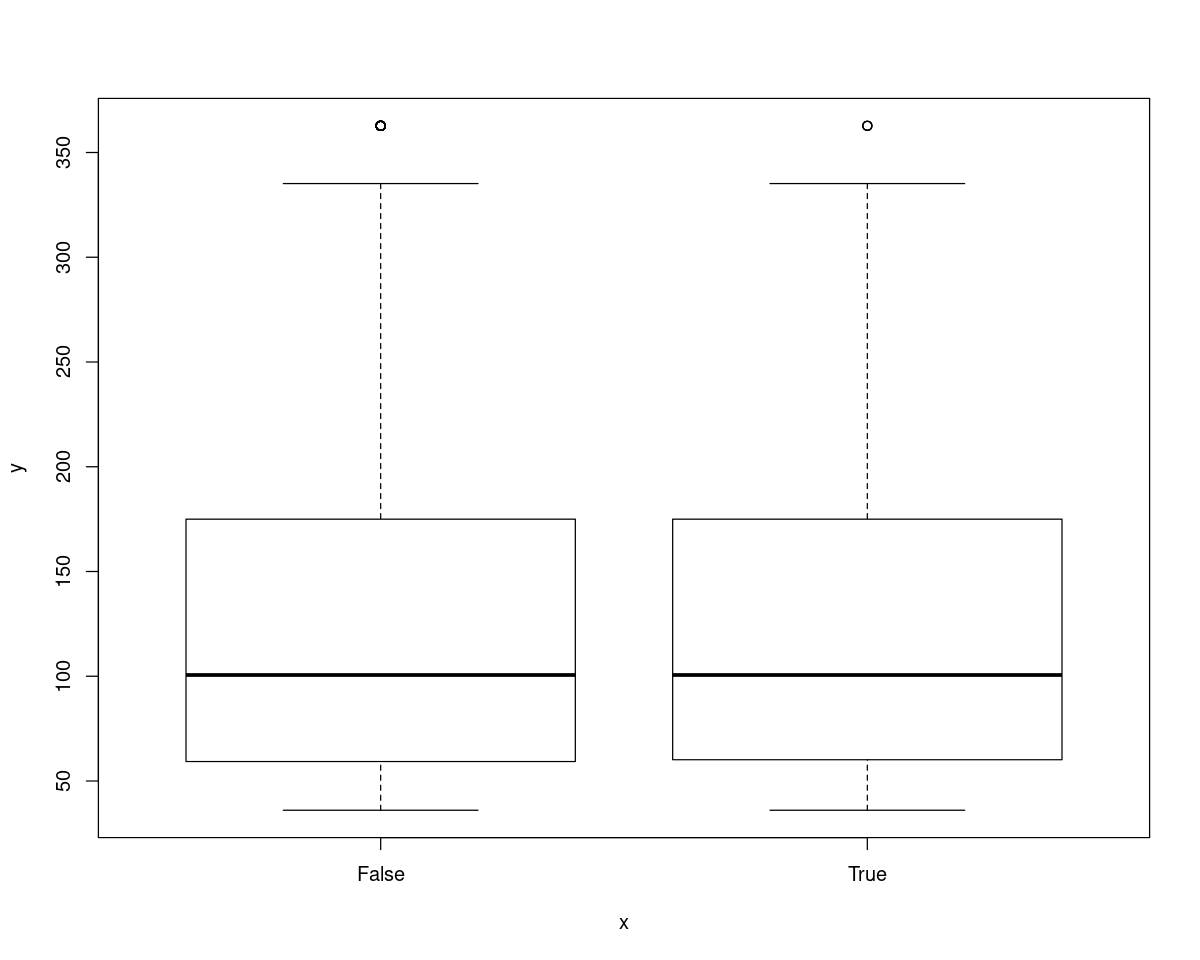

In [37]:
# MI with smha_exp_per_capita - No difference
plot(signs_of_mental_illness, smha_exp_per_capita)

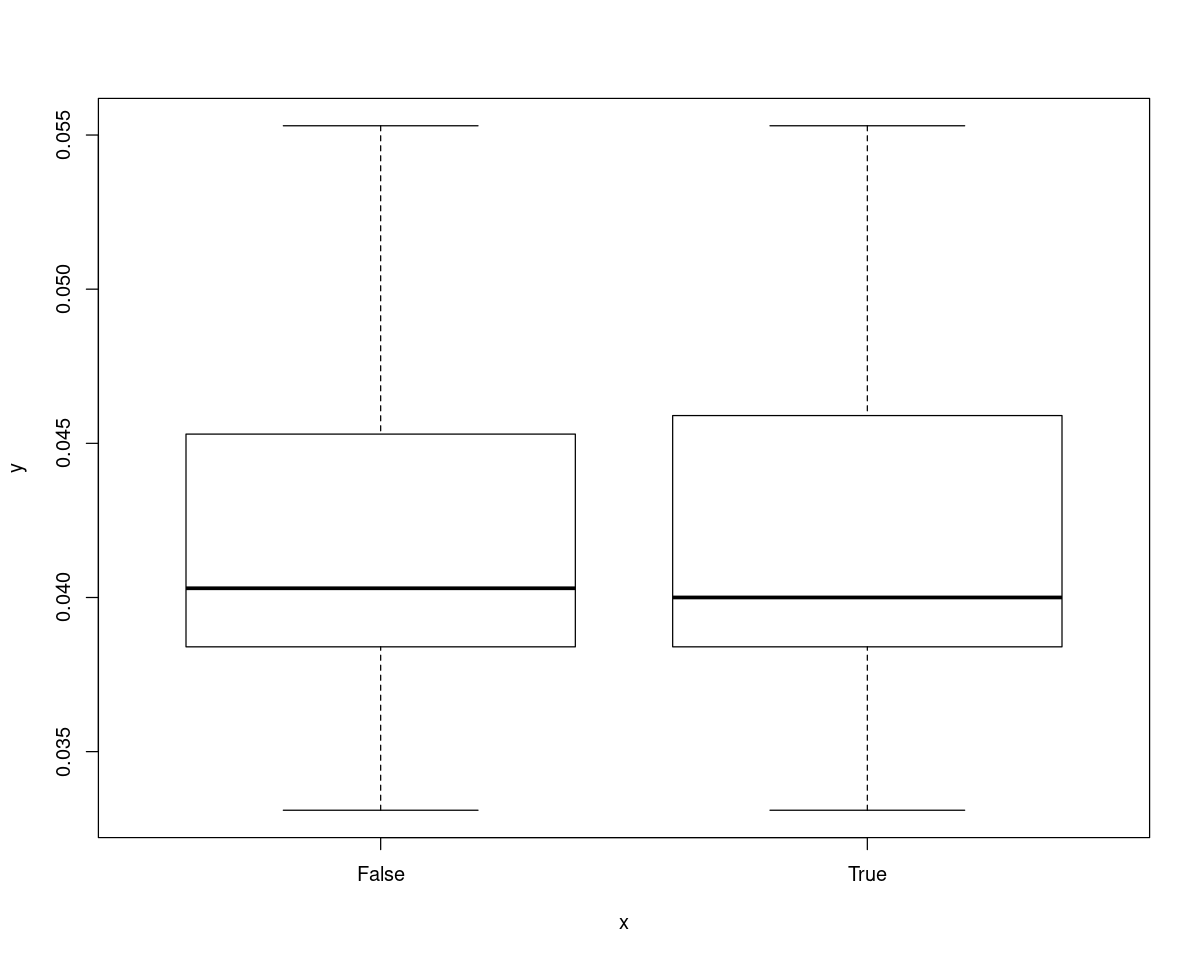

In [38]:
# MI with smi_prevalance - No difference
plot(signs_of_mental_illness, smi_prevalance)

Check GGPairs

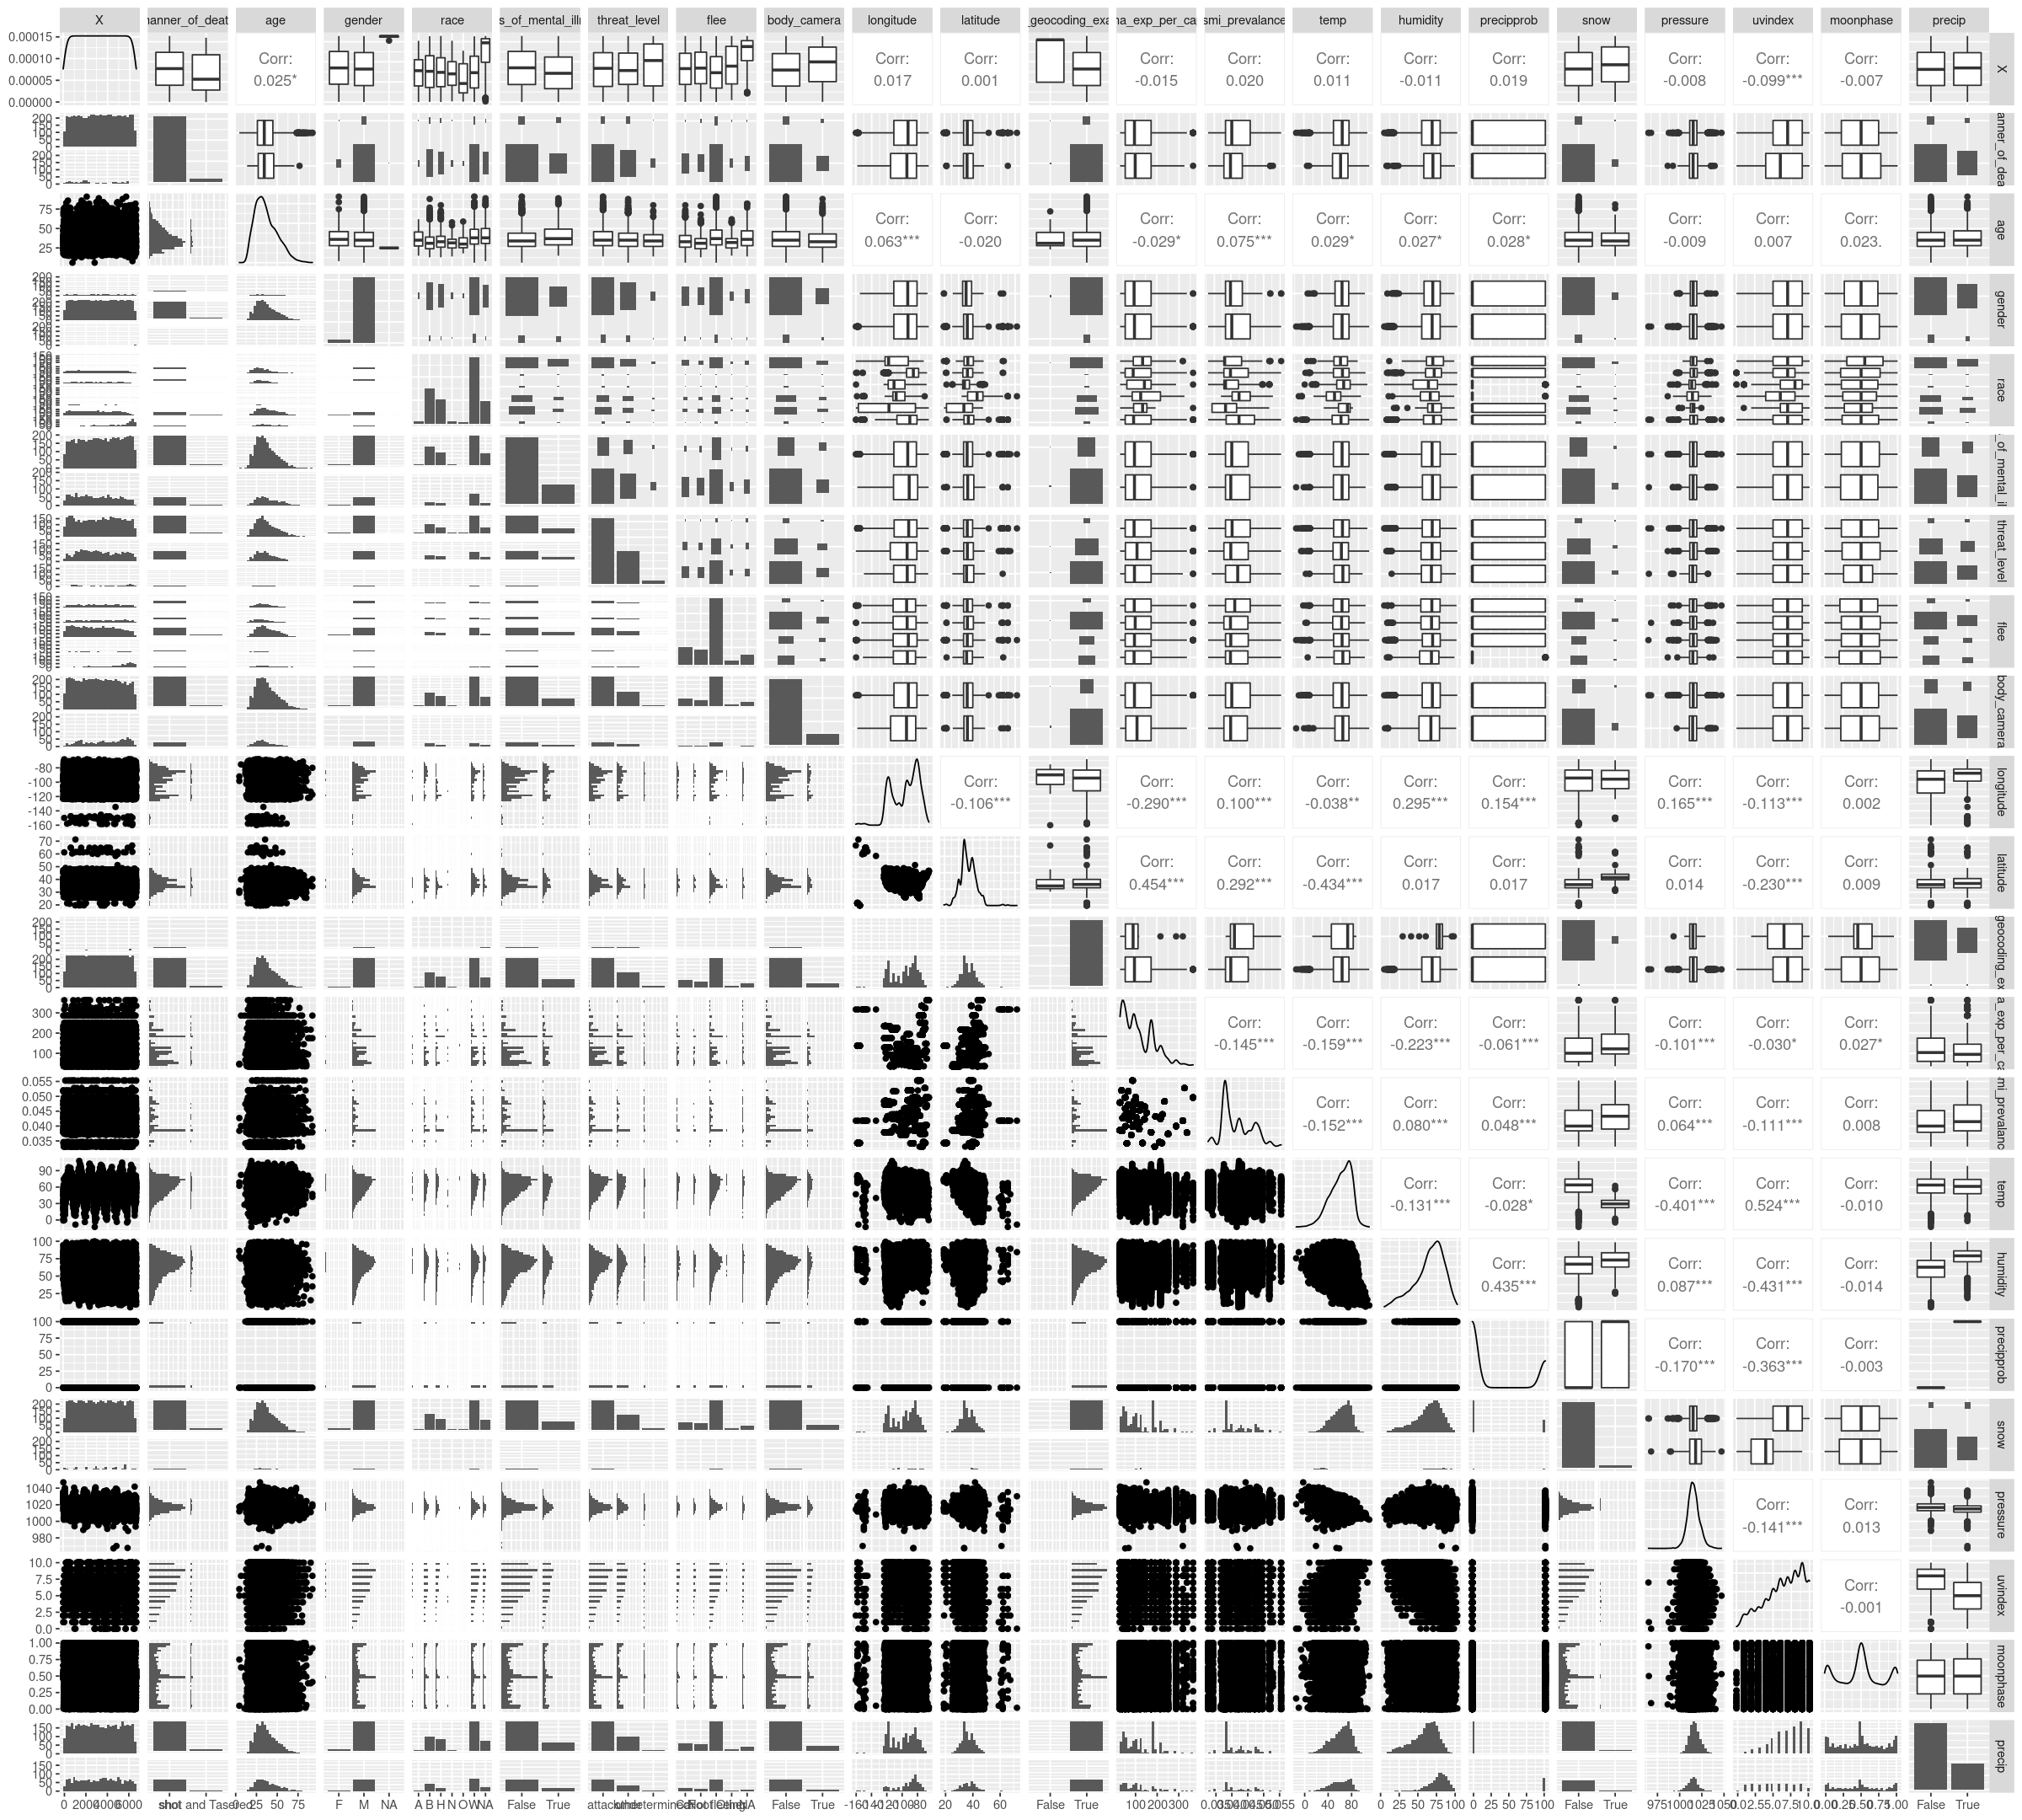

In [39]:
options(repr.plot.width=20, repr.plot.height=18)
ggpairs(data[,!(names(data) %in% c("date", "armed", "state"))])

#### Year-wise counts
2015:994<br>2016:958<br>2017:981<br>2018:985<br>2019:999<br>2020:1020<br>2021:1054<br>2022:300

### Missingness patterns

Check missing data frequency for each column

In [40]:
# Percent missing values per column
as.data.frame((colMeans(is.na(data)))*100)

,(colMeans(is.na(data))) * 100
,<dbl>
X,0.00000000
date,0.00000000
manner_of_death,0.00000000
armed,0.00000000
age,5.13755890
gender,0.09119927
race,14.65268278
state,0.00000000
signs_of_mental_illness,0.00000000


Check patterns in data missingness

Warning message:
“`gather_()` was deprecated in tidyr 1.2.0.
Please use `gather()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


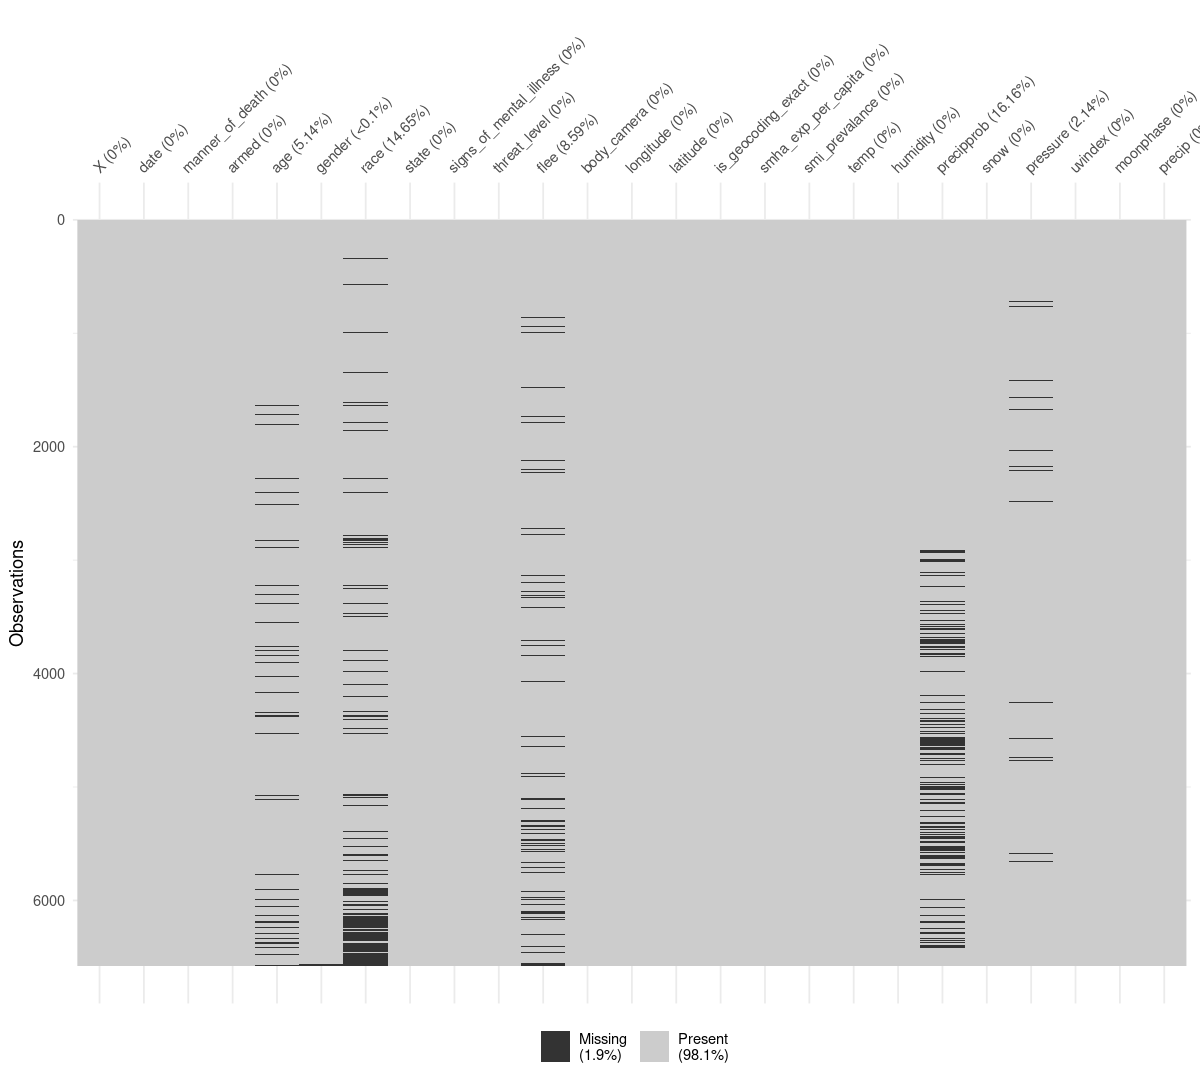

In [41]:
options(repr.plot.width=10, repr.plot.height=9)
vis_miss(data)

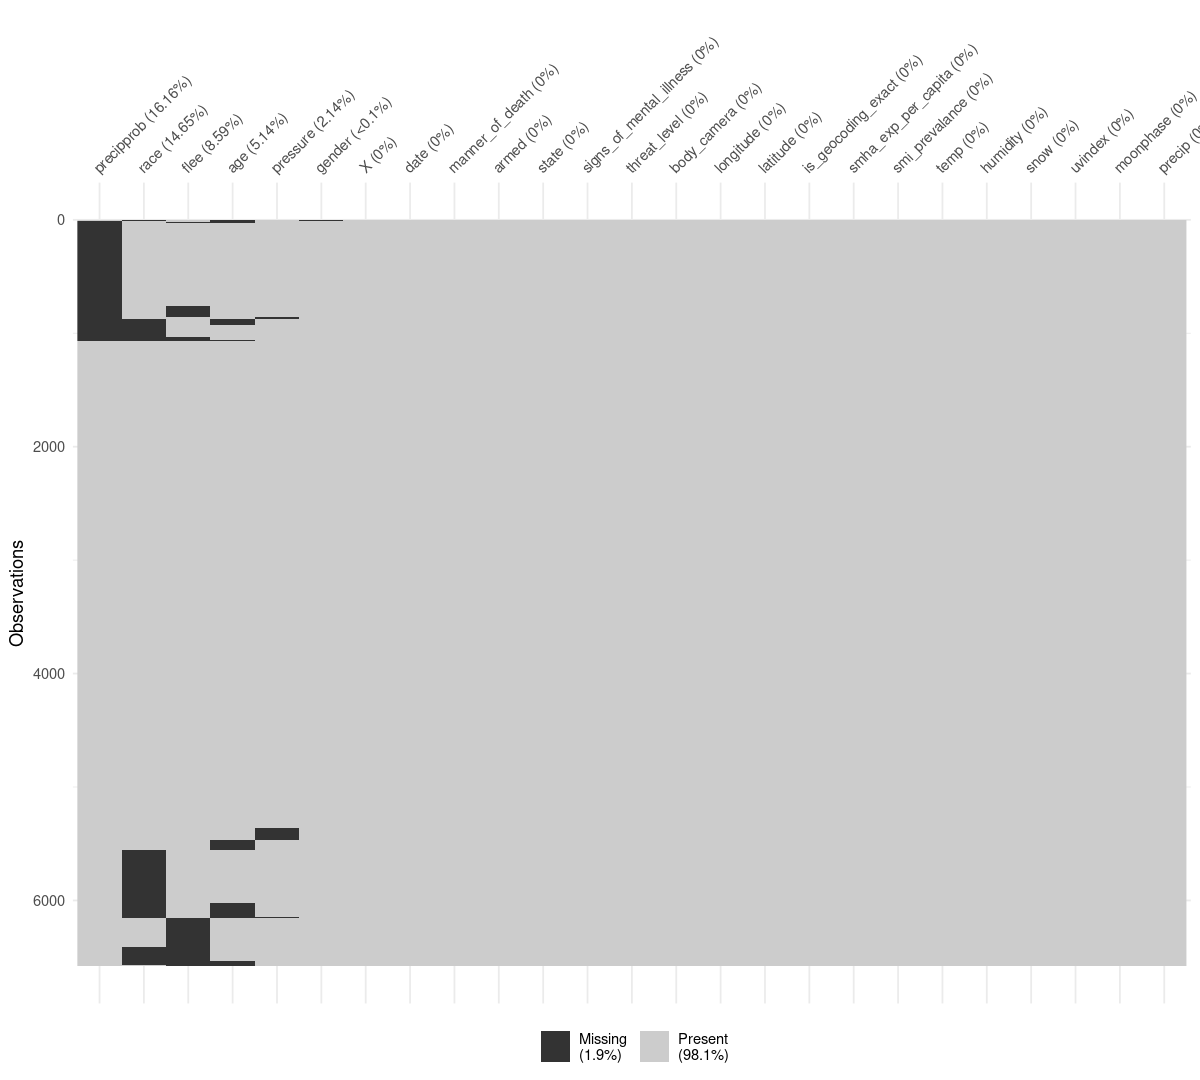

In [42]:
vis_miss(data, cluster = TRUE, sort_miss = TRUE)

#### To add in EDA:
1. Rolling average (over time) of proportion of victims showing evidence of mental illness - overall and by race
2. The proportion of people afflicted in the general population vs in this dataset - possibly break down by state

In [43]:
head(data)

,X,date,manner_of_death,armed,age,gender,race,state,signs_of_mental_illness,threat_level,⋯,smha_exp_per_capita,smi_prevalance,temp,humidity,precipprob,snow,pressure,uvindex,moonphase,precip
,<int>,<date>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
1,0,2015-01-02,shot,gun,53,M,A,WA,True,attack,⋯,128.46,0.0472,32.0,94.4,100,False,1021.1,2,0.46,True
2,1,2015-01-02,shot,gun,47,M,W,OR,False,attack,⋯,234.87,0.0483,32.2,75.9,0,False,1023.6,3,0.46,False
3,2,2015-01-03,shot and Tasered,unarmed,23,M,H,KS,False,other,⋯,124.11,0.0412,32.7,84.7,100,False,1013.3,3,0.49,True
4,3,2015-01-04,shot,other,32,M,W,CA,True,attack,⋯,174.98,0.0379,46.3,76.2,0,False,1028.6,4,0.50,False
5,4,2015-01-04,shot,other,39,M,H,CO,False,attack,⋯,121.90,0.0390,1.4,70.3,0,False,NA,5,0.50,False
6,5,2015-01-04,shot,gun,18,M,W,OK,False,attack,⋯,59.29,0.0459,21.5,59.0,0,False,1034.9,6,0.50,False


In [44]:
# The proportion of fatal shootings where SMI is True
# head(data)
data = data %>% mutate(yr = year(date))
smi_data = data %>% filter(signs_of_mental_illness == 'True')
total_counts_by_state_year = aggregate(data$signs_of_mental_illness, by=list(data$state, data$yr), FUN=length)
smi_counts_by_state_year = aggregate(smi_data$signs_of_mental_illness, by=list(smi_data$state, smi_data$yr), FUN=length)

props_by_state_year = merge(total_counts_by_state_year, smi_counts_by_state_year, by=c("Group.1", "Group.2"), all = TRUE)
props_by_state_year$x.y[is.na(props_by_state_year$x.y)] <- 0
props_by_state_year$per = props_by_state_year$x.y / props_by_state_year$x.x

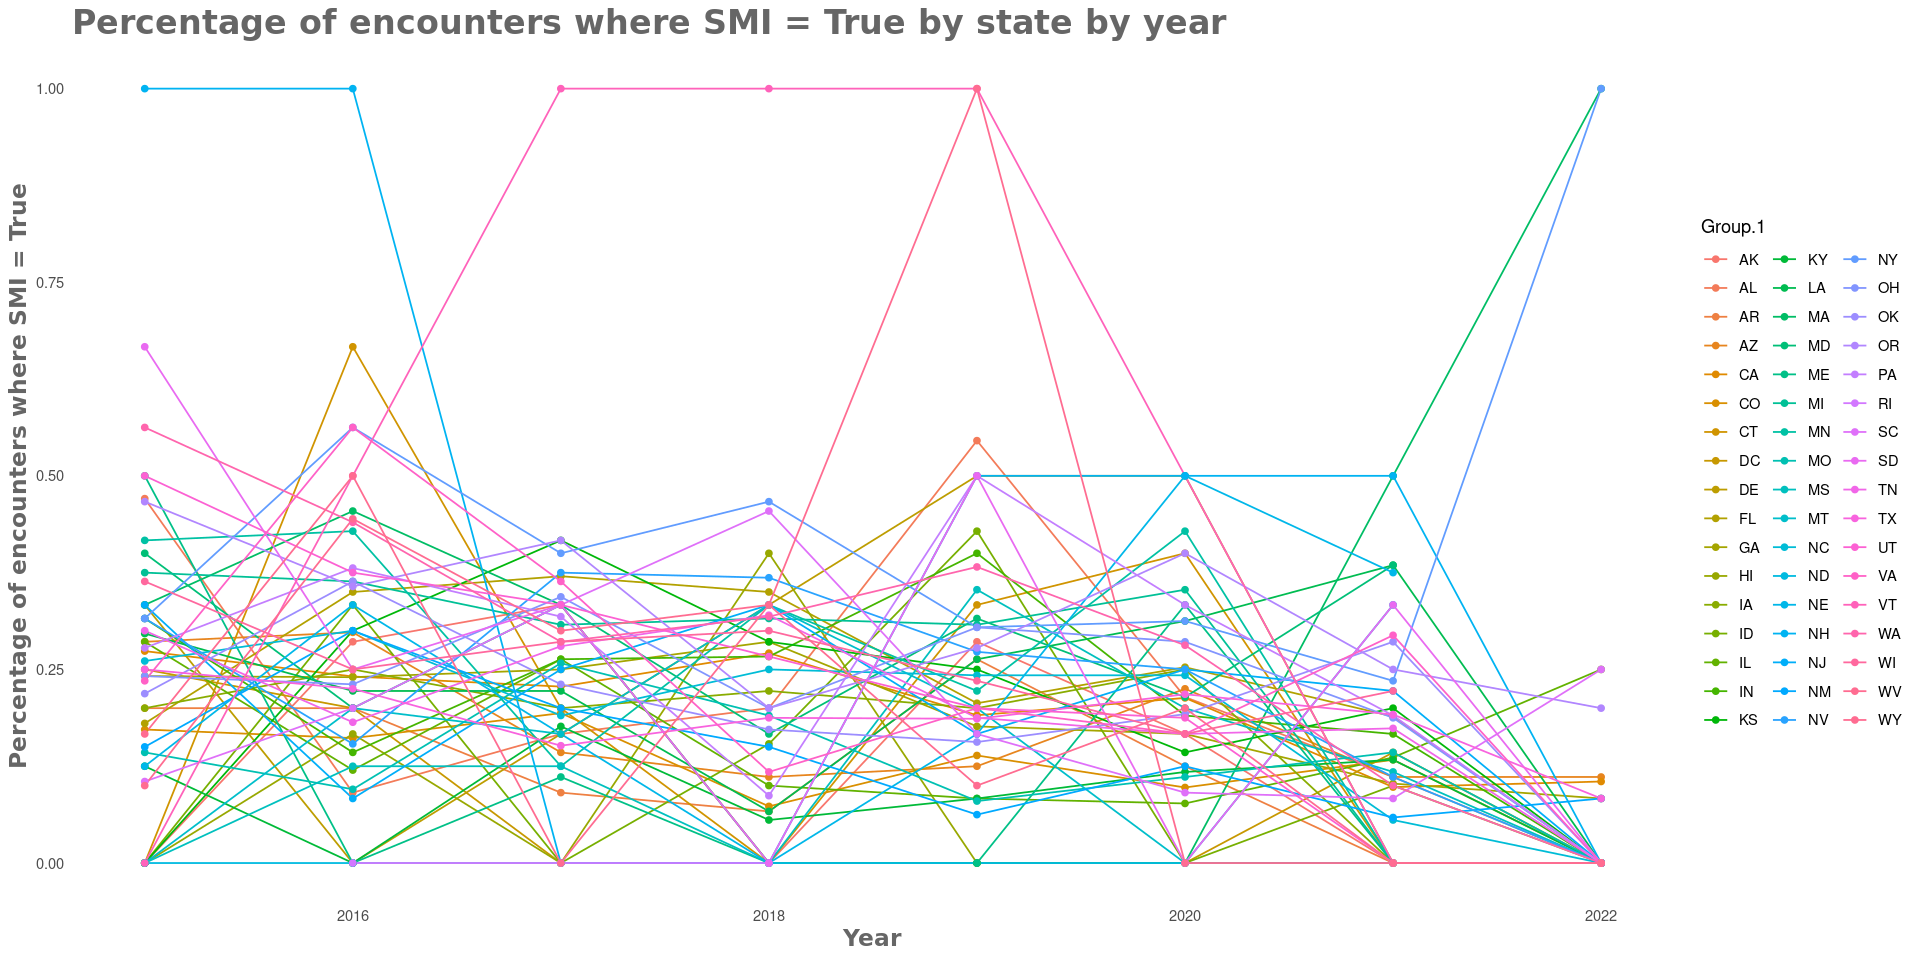

In [54]:
options(repr.plot.width=16, repr.plot.height=8)
ggplot(data=props_by_state_year,
       aes(x=Group.2, y=per, colour=	Group.1)) +
       geom_line() + geom_point() + theme_minimal() +
       xlab("Year") +
       ylab("Percentage of encounters where SMI = True") +
       ggtitle("Percentage of encounters where SMI = True by state by year") + 
       theme(plot.title = element_text(family = "Trebuchet MS", color="#666666", face="bold", size=20, hjust=0)) + 
       theme(axis.title = element_text(family = "Trebuchet MS", color="#666666", face="bold", size=14)) + 
       theme(panel.grid.major = element_blank(),
              panel.grid.minor = element_blank(),
              panel.border = element_blank(),
              panel.background = element_blank())

In [46]:
head(props_by_state_year[order(-props_by_state_year$per),])

,Group.1,Group.2,x.x,x.y,per
,<fct>,<dbl>,<int>,<dbl>,<dbl>
155,MA,2022,1,1,1
231,NH,2015,3,3,1
232,NH,2016,2,2,1
270,NY,2022,1,1,1
355,VT,2017,1,1,1
356,VT,2018,2,2,1


In [47]:
# The proportion of fatal shootings where SMI is True

# Race -> Combine A/N/O/NA under O?
data = data %>% 
  mutate(race = case_when(
    race == "W" ~ "W",
    race == "B" ~ "B",
    race == "H" ~ "H",
    TRUE ~ "O",
  )
)
data$race = as.factor(data$race)
summary(data$race)

total_counts_by_race_year = aggregate(data$signs_of_mental_illness, by=list(data$race, data$yr), FUN=length)
smi_counts_by_race_year = aggregate(smi_data$signs_of_mental_illness, by=list(smi_data$race, smi_data$yr), FUN=length)

props_by_race_year = merge(total_counts_by_race_year, smi_counts_by_race_year, by=c("Group.1", "Group.2"), all = TRUE)
props_by_race_year$x.y[is.na(props_by_race_year$x.y)] <- 0
props_by_race_year$per = props_by_race_year$x.y / props_by_race_year$x.x

B    H    O    W 
1500 1046 1194 2839

In [48]:
# Race has been recorded for only 2 shootings in 2022
props_by_race_year = props_by_race_year %>% filter(Group.2 != 2022)

Warning message:
“Removed 12 row(s) containing missing values (geom_path).”
Warning message:
“Removed 12 rows containing missing values (geom_point).”


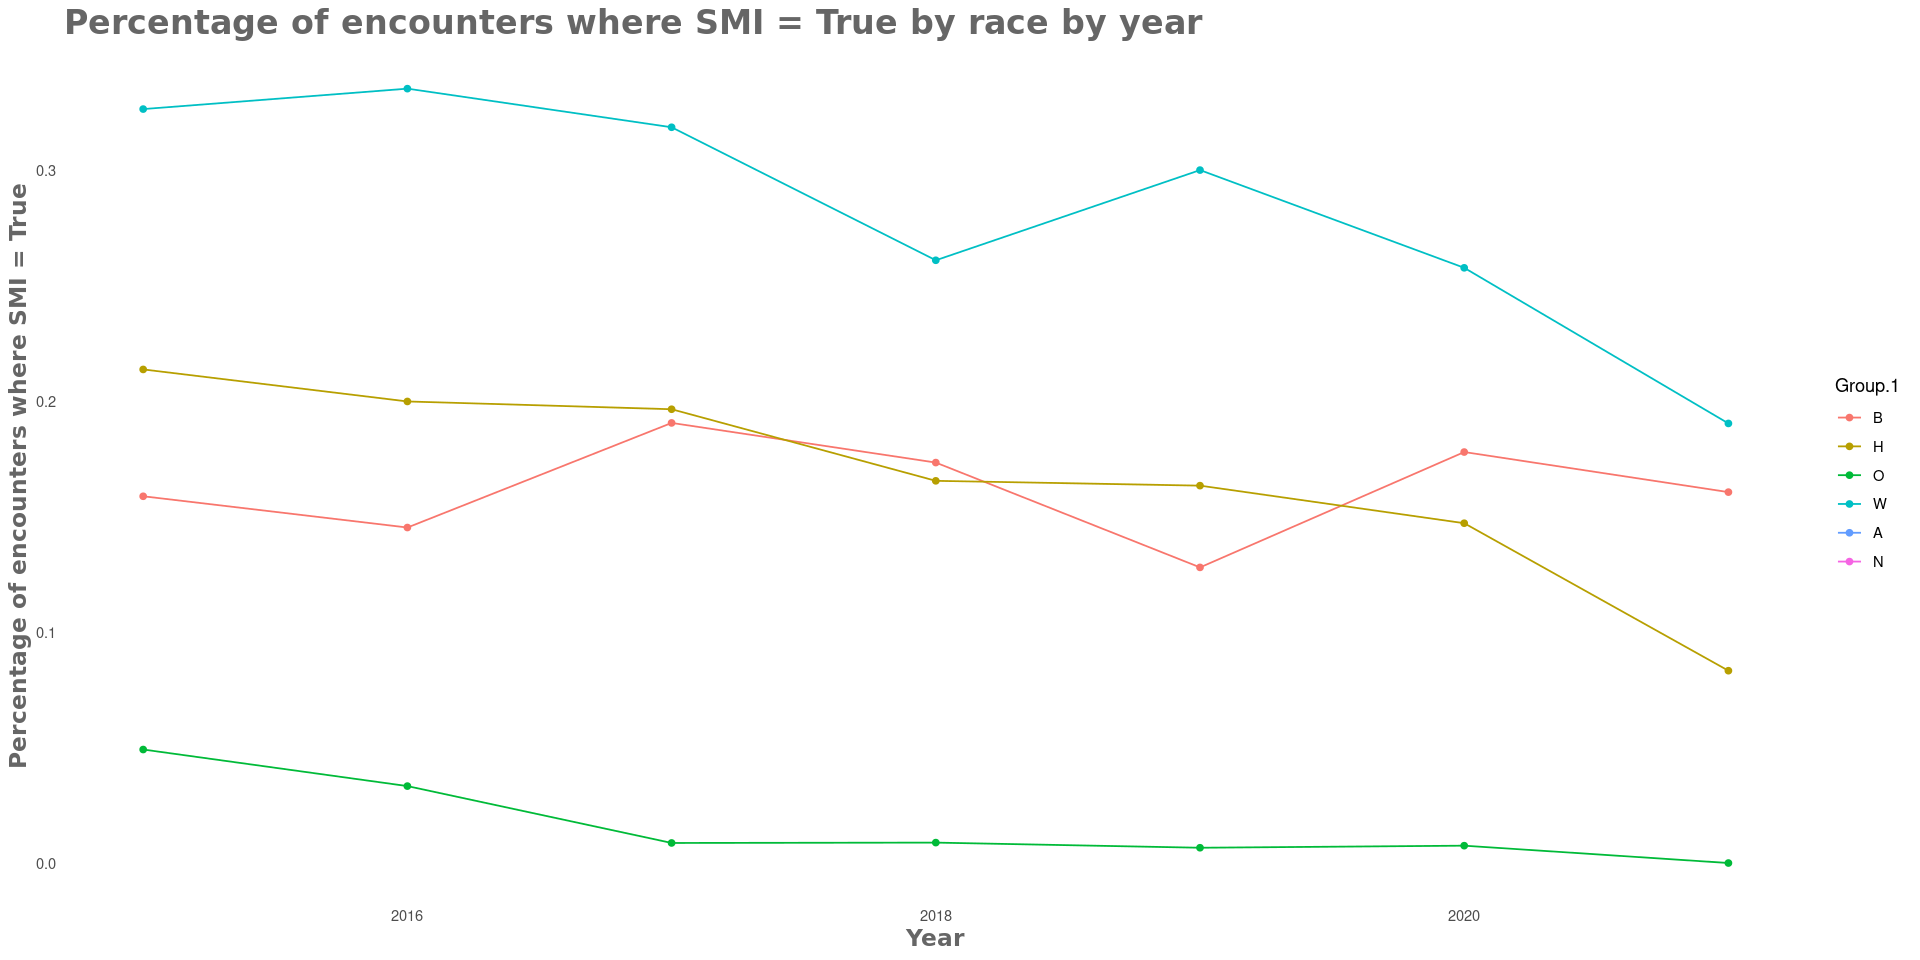

In [55]:
options(repr.plot.width=16, repr.plot.height=8)
ggplot(data=props_by_race_year,
       aes(x=Group.2, y=per, colour=Group.1)) +
       geom_line() + geom_point() + theme_minimal() +
       xlab("Year") +
       ylab("Percentage of encounters where SMI = True") +
       ggtitle("Percentage of encounters where SMI = True by race by year") +
       theme(plot.title = element_text(family = "Trebuchet MS", color="#666666", face="bold", size=20, hjust=0)) + 
       theme(axis.title = element_text(family = "Trebuchet MS", color="#666666", face="bold", size=14)) + 
       theme(panel.grid.major = element_blank(),
              panel.grid.minor = element_blank(),
              panel.border = element_blank(),
              panel.background = element_blank())

### General qns about data

"shot and Tasered" has 339 entries vs "shot" which has 6952 entries -> drop this feature? Not sure that it would affect our outcome

Convert age to categorical variable by binning?

Tranform the "armed" feature into Unarmed/gun/knife/vehicle/other? There are too many different values at the moment

Keep one of smha_exp_per_capita and smi_prevalance, depending on which one is more predictive

What are the dimensions along which we should consider random effects/random slopes?

Fit splines for anything?

How will we split the data? 

Any interactions that we should consider?

Use Poisson model?

How do we factor in the time dimension?
 1. Consider longitudinal by time
 2. Run separate regressions for 2015:16, 17:18, ... ? This can give us changing interpretations of different models (also extra residual analyses??)
 3. Take 2015-01-01 = day 0, and then convert dates to continuous feature that gets incorporated?

Add weights to the GLM model to handle imbalance in data (Weights <- ifelse(df$mental_illness == 1, 1/0.15, 1/0.85))

### Narrowing down list of features to consider

To drop: "id", "name", "city", "manner_of_death", "longitude", "latitude", "is_geo_coding_exact" (last 3 after pulling in weather info)

Continuous features:
1. age
2. smha_exp_per_capita
3. smi_prevalance

Categorical features:
1. armed
2. gender
3. race
4. state
5. threat_level
6. flee
7. body_camera
8. weather?